# Content Analysis

Two main questions: how does language differ across provinces? And how does language differe over time.

In [1]:
from utils import DTYPE, PARSE_DATES, PROV_CONSOLIDATION, CONSOLIDATED_PROVINCES, CONVERTERS
from tqdm.auto import tqdm
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import glob

prov_map = lambda x : x if x not in PROV_CONSOLIDATION else PROV_CONSOLIDATION[x]

data_paths = glob.glob("../data/processed_data/*.csv")
frames = [pd.read_csv(f,header=0,dtype=DTYPE,converters=CONVERTERS,parse_dates=PARSE_DATES) for f in tqdm(data_paths)]
total_df = pd.concat(frames, axis=0, ignore_index=True).set_index("id").sort_values("created_at")
total_df = total_df[~total_df.index.duplicated()]

total_df["created_at"] = total_df["created_at"].dt.to_period("D").dt.to_timestamp('s')
total_df["province"] = total_df["province"].apply(prov_map)
total_df = total_df[total_df.clean_text.notnull()]
print(len(total_df))
total_df.head()


349786


/Users/cameron/.local/share/virtualenvs/COVID-Child-Care-Twitter-vC7O4c45/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,created_at,screen_name,source,clean_text,original_text,is_retweet,favorite_count,retweet_count,hashtags,urls,mentions,city,province,longitude,latitude
id,,,,,,,,,,,,,,,
1228469111451242497,2020-02-15,Transport_gc,Hootsuite Inc.,improve roadsafety canada many priority pilot ...,Improving #RoadSafety in #Canada is one of our...,False,9,1,"[RoadSafety, Canada, seatbelts]",[https://twitter.com/i/web/status/122846911145...,,NaN,NaN,-113.64258,60.10867
1228470050996113408,2020-02-15,4Everanimalz1,Twitter for iPad,improve roadsafety canada many priority pilot ...,Improving #RoadSafety in #Canada is one of our...,True,0,0,"[RoadSafety, Canada, seatbelts]",,[Transport_gc],Calgary,Alberta,-114.08529,51.05011
1228470466668564481,2020-02-15,Mom_ASDadvocate,Twitter for iPhone,student tcdsb would nice walk place know safe ...,"to me, a student in the TCDSB, this would be s...",True,0,0,,,[leahbanning],Toronto,Ontario,-79.41630,43.70011
1228470535530647552,2020-02-15,camille4change,Twitter for iPhone,student tcdsb would nice walk place know safe ...,"to me, a student in the TCDSB, this would be s...",True,0,0,,,[leahbanning],Hamilton,Ontario,-79.84963,43.25011
1228472099464810498,2020-02-15,DianneWatts4BC,Twitter for iPhone,still discuss pilot do already safety kid rid ...,Why is this still being discussed and piloted ...,False,27,4,,[https://twitter.com/i/web/status/122847209946...,,Surrey,British Columbia,-122.82509,49.10635


## Wordclouds

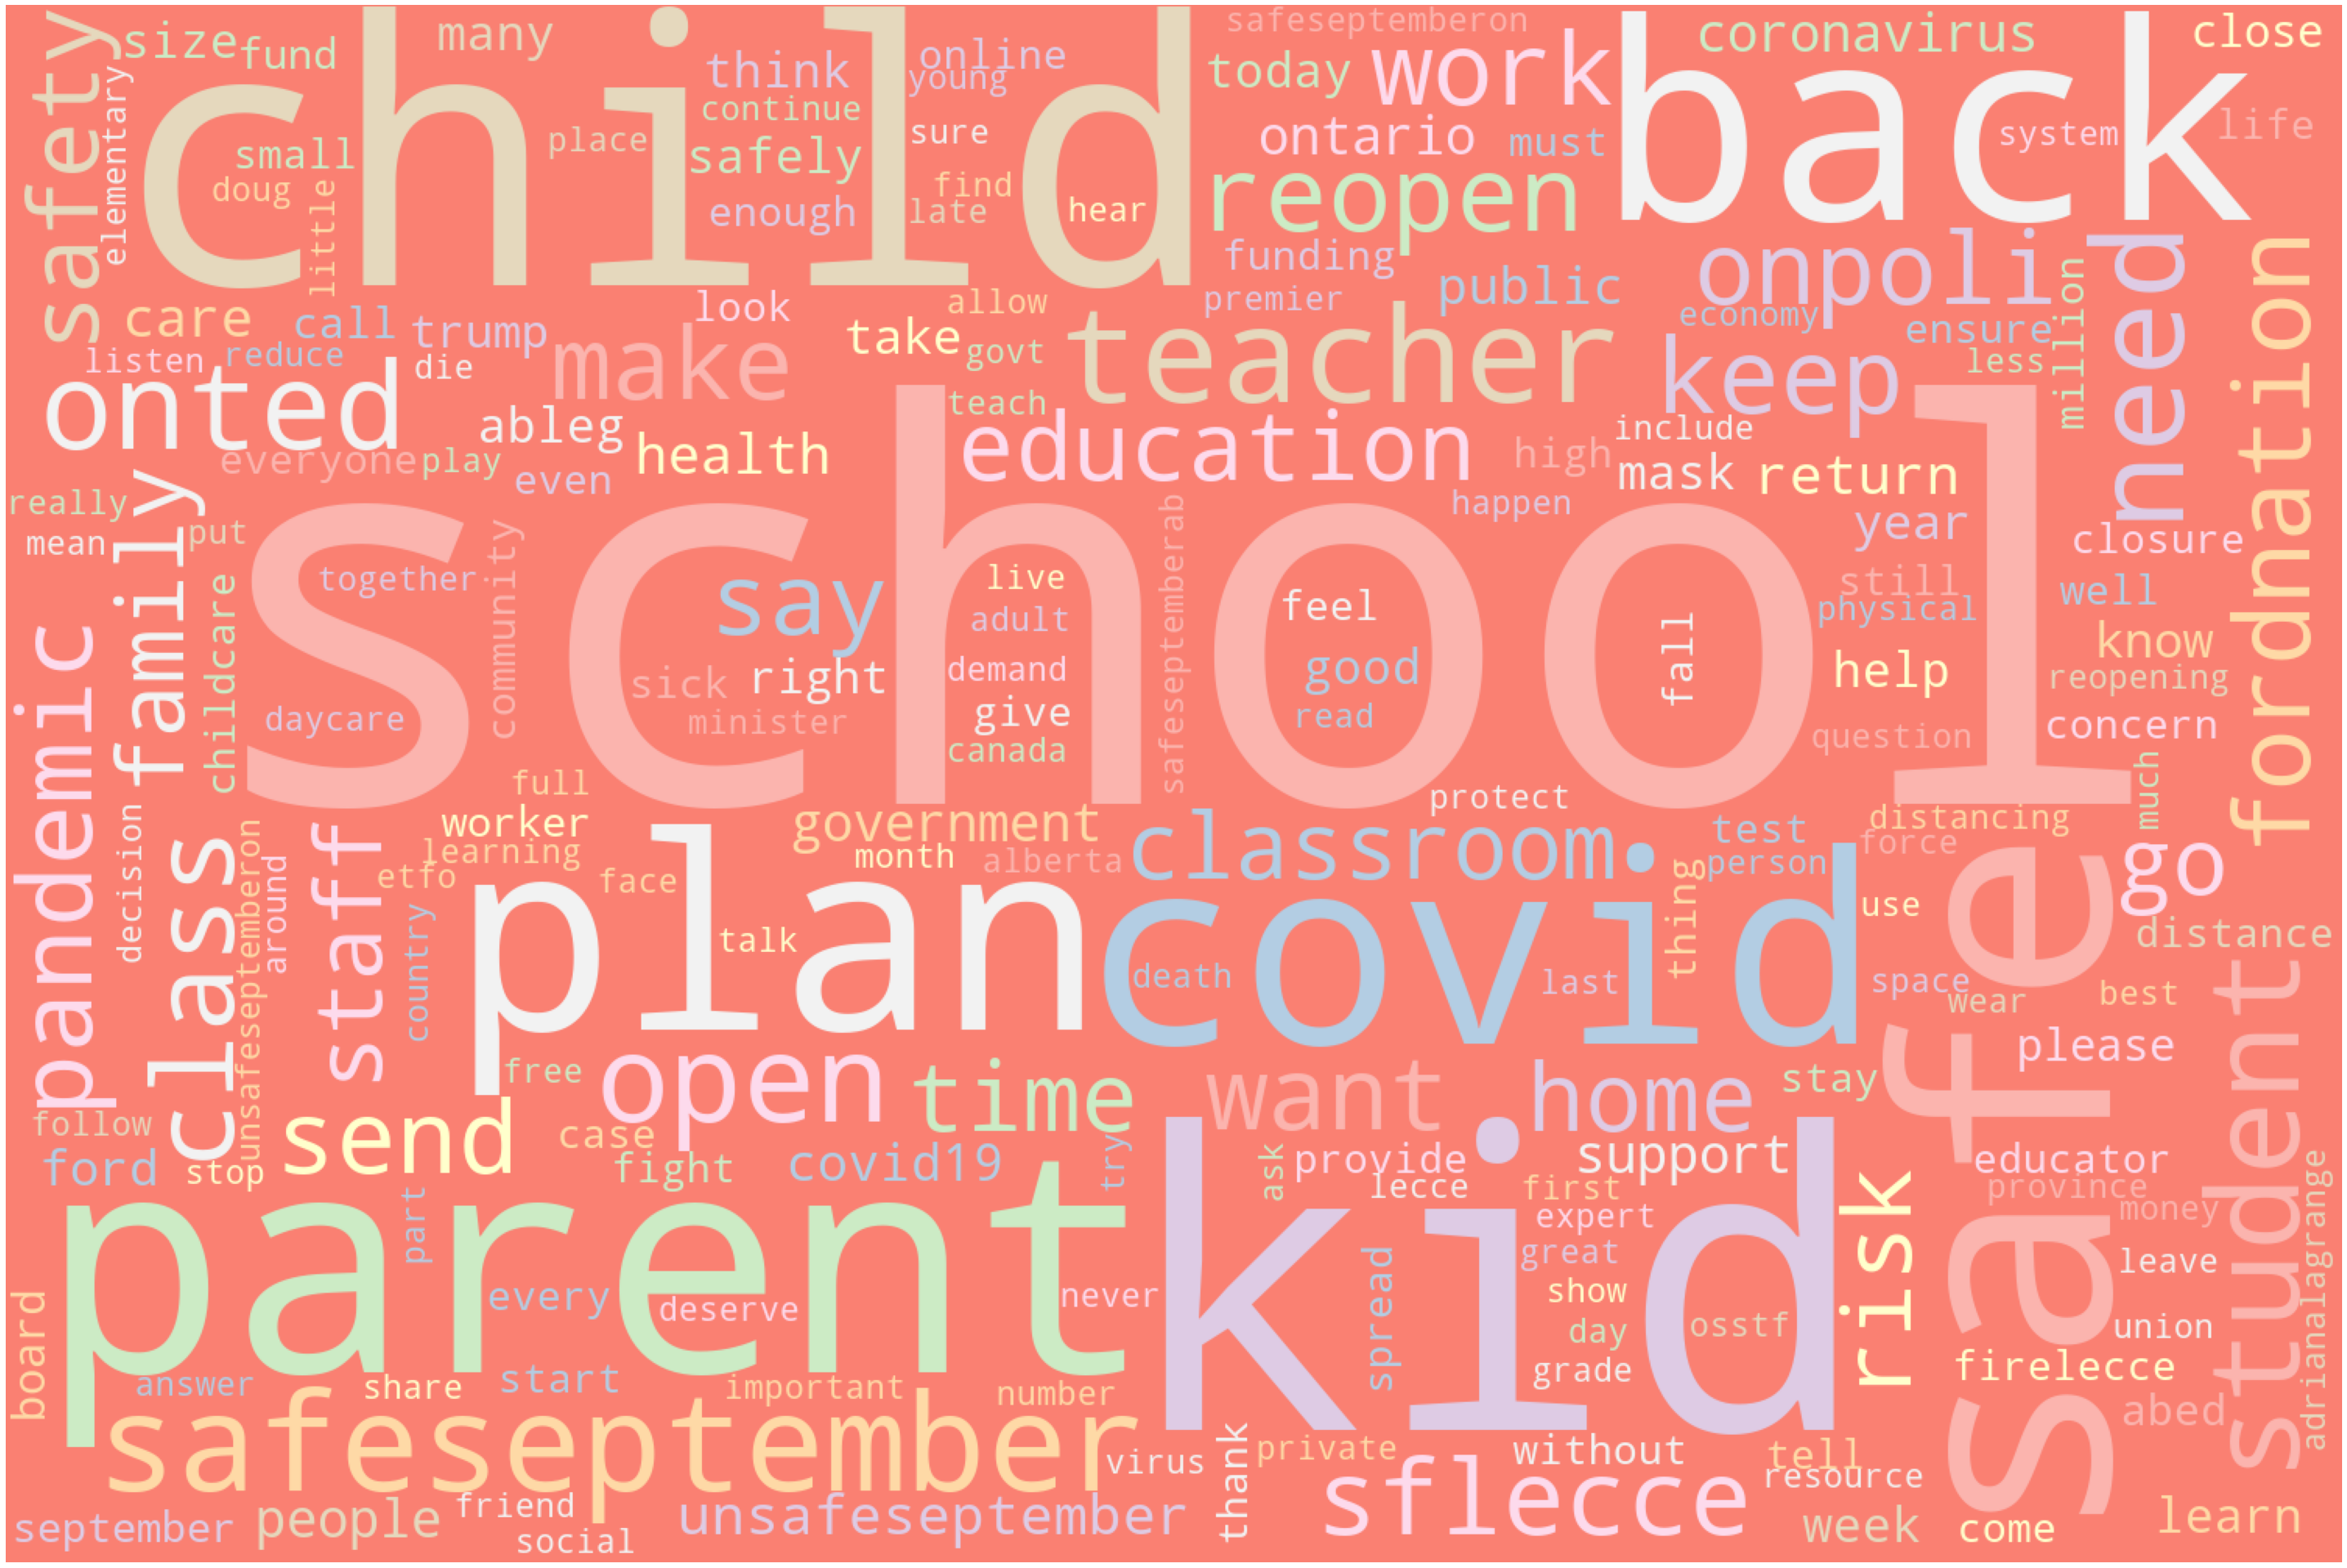

In [2]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

text = ' '.join(total_df[total_df.clean_text.notnull()]['clean_text'])
wordcloud = WordCloud(width=1500,
                      height=1000,
                      random_state=1,
                      background_color='salmon',
                      colormap='Pastel1',
                      collocations=False,
                      stopwords=STOPWORDS).generate(text)# Plot
# Set figure size
plt.figure(figsize=(40, 30))
# Display image
plt.imshow(wordcloud) 
# No axis details
plt.axis("off");
plt.tight_layout()
# plt.savefig("../visualizations/content_analysis/wordclouds/wordcloud.png")

In [ ]:
fig = plt.figure(figsize=(10,15))
for i,prov in enumerate(CONSOLIDATED_PROVINCES):
    ax = fig.add_subplot((len(CONSOLIDATED_PROVINCES)//2)+1,2,i+1)
    text = total_df[total_df.clean_text.notnull()]
    text = ' '.join(text[text["province"] == prov]["clean_text"])
    wordcloud = WordCloud(height=1000,
                          width=1500,
                          random_state=1,
                          background_color='salmon',
                          colormap='Pastel1',
                          collocations=False,
                          stopwords=STOPWORDS).generate(text)# Plot

    ax.imshow(wordcloud)
    ax.set_title(f"{prov} Wordcloud")
    ax.axis('off')
plt.tight_layout()
# plt.savefig("../visualizations/content_analysis/wordclouds/province_breakdown-wordcloud.png")

## Log Odds Ratio

Source: `Monroe, Burt L., Michael P. Colaresi, and Kevin M. Quinn. "Fightin'words: Lexical feature selection and evaluation for identifying the content of political conflict." Political Analysis 16, no. 4 (2008): 372-403.`

Odds for a word $w$ in a class of documents $i$ is $O^{(i)}_{w}=\frac{f^{(i)}_{w}}{(1-f^{(i)}_{w})}$

Odds ratio for two classes (candidates) would be $\theta^{(i_1 - i_2)}_{w} = \frac{O^{(i^1)}_{w}}{O^{(i^2)}_{w}}$

Log odds ratio would then be $log(\theta^{(i_1 - i_2)}_{w})$

By logging the odds ratio we can compare the odds ratio of words across classes


In [ ]:
def filter_dict(a_dict,thresh=0.0001,n=None):
    if n:
        return {key: val for key,val in a_dict.items() if val/n > thresh}
    return {key: val for key,val in a_dict.items() if val > thresh}

to_odds = lambda x : (x/(1-x+0.001))
log_odds_ratio = lambda o1,o2 : np.log((o1+0.001)/(o2+0.001))

In [ ]:
province_count = {}
province_prob = {}
total_df["clean_text"] = total_df["clean_text"].apply(lambda x : x.split())
for prov in CONSOLIDATED_PROVINCES:
    iso = total_df[total_df["province"] == prov]
    word_count = pd.Series(np.concatenate([x for x in iso["clean_text"]])).value_counts()
    n = word_count.sum()
    province_count[prov] = filter_dict(word_count.to_dict(),n=n)
    word_prob = filter_dict((word_count/n).to_dict())
    province_prob[prov] = word_prob

word_count = pd.Series(np.concatenate([x for x in total_df["clean_text"]])).value_counts()
n = word_count.sum()
province_count["Total"] = filter_dict(word_count.to_dict(),n=n,thresh=0)
word_prob = filter_dict((word_count/n).to_dict())
province_prob["Total"] = word_prob

province_count = pd.DataFrame.from_dict(province_count).fillna(0)
province_count["total"] = province_count.sum(axis=1)
province_prob = pd.DataFrame.from_dict(province_prob).fillna(0)

province_count.index.name,province_prob.index.name = "word","word"
province_prob

In [ ]:
from utils import PROVINCE_COLOR_MAP

master_log_odds = province_prob.copy().applymap(lambda x : to_odds(x))

for prov in CONSOLIDATED_PROVINCES:
    master_log_odds[prov] = master_log_odds.apply(lambda x : log_odds_ratio(x[prov],x["Total"]),axis=1)
master_log_odds = master_log_odds.reset_index()
master_log_odds = master_log_odds.melt(id_vars=["word"], value_vars=CONSOLIDATED_PROVINCES,var_name="province",value_name="log_odds")
master_log_odds = master_log_odds.merge(province_count["Total"],how="left",left_on="word",right_index=True)

annotations = []
for prov in CONSOLIDATED_PROVINCES:
    iso = master_log_odds[master_log_odds["province"] == prov].sort_values("log_odds",ascending=False)
    annotations += [dict(x = np.log10(row["Total"]),
                        y = row["log_odds"],
                        text = row["word"]) 
                   for _,row in 
                   iso.head(3).iterrows() if row["Total"]>0]
xmax = master_log_odds["Total"].max()*0.9
ymax,ymin = master_log_odds["log_odds"].max()*1.1, master_log_odds["log_odds"].min()*1.1
annotations += [dict(x= np.log10(xmax),y=ymax,showarrow=False,text="<b>Province Specific</b>"),
                dict(x= np.log10(xmax),y=0,showarrow=False,text="<b>General Usage</b>"),
                dict(x= np.log10(xmax),y=ymin,showarrow=False,text="<b>Other Provinces</b>")]
    

fig = px.scatter(master_log_odds,
                 x="Total",
                 y="log_odds",
                 color="province",
                 hover_data=['word'],
                 opacity=0.5,
                 color_discrete_map=PROVINCE_COLOR_MAP,
                 labels={
                     "Total": "Word Frequency (All Provinces)",
                     "log_odds": "Log Odds Ratio Against All Provinces",
                     "subreddit": "Subreddit",
                     "word": "Word"
                 })
args = {
#     "font":{"size": 16},
    "template": "simple_white",
    "title": "Log Odds Ratio of Word Usage",
    "annotations": annotations,
    "height": 1000
}
fig.update_layout(**args)
fig.update_xaxes(type="log")
fig.write_html("../visualizations/content_analysis/log_odds/all_provinces-log_odds_ratio.html")
fig.show()


In [ ]:
n = 20
for prov in CONSOLIDATED_PROVINCES:
    iso = master_log_odds[master_log_odds["province"] == prov].sort_values("log_odds",ascending=False)
    print(iso.head(n))